# O$_3$ analysis with GOSAT-TIR

In [16]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
%config InlineBackend.figure_format = 'retina'
import os
os.environ["PROJ_LIB"] = "C:\\Users\\admin\Anaconda3\Library\share"
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Parameters

## Read file

In [2]:
nfile = 'D:\OneDrive - chiba-u.jp\Students\Ozone\inp_data\O3_V01.00_201001_rlay.txt'
df_r = pd.read_table(nfile, header=None, delim_whitespace=True)

## Manage columns

In [26]:
df = df_r.copy()
columns = ['id', 'yy', 'mm', 'dd', 'hh', 'mn', 'lon', 'lat', 'prs', 'o3', 
           'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
df = pd.DataFrame(df.values, columns = columns)
df.drop(columns=['id', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'], inplace = True)
df['index'] = pd.to_datetime(
    dict(year=df.yy, month=df.mm, day=df.dd, hour=df.hh, minutes=df.mn), errors='coerce')
df.set_index('index', inplace=True)
df = df.apply(pd.to_numeric)
df['ps'] = df.prs.apply(lambda x: 1 if x <100 else np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2592141 entries, 2010-01-01 00:01:00 to 2010-01-31 23:59:00
Data columns (total 10 columns):
 #   Column  Dtype  
---  ------  -----  
 0   yy      int64  
 1   mm      int64  
 2   dd      int64  
 3   hh      int64  
 4   mn      int64  
 5   lon     float64
 6   lat     float64
 7   prs     float64
 8   o3      float64
 9   ps      float64
dtypes: float64(5), int64(5)
memory usage: 217.5 MB


In [27]:
df_s = df.copy()
df_s.dropna(inplace=True)
# df_s1 = df_s.resample('M').mean()
df_s.drop(columns=['yy', 'mm', 'dd', 'hh', 'mn', 'prs', 'ps'], inplace = True)
df_s['lon'] = df_s.lon.apply(lambda x: x if x < 180 else x-360)
df_s.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1307544 entries, 2010-01-01 00:01:00 to 2010-01-31 23:59:00
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   lon     1307544 non-null  float64
 1   lat     1307544 non-null  float64
 2   o3      1307544 non-null  float64
dtypes: float64(3)
memory usage: 39.9 MB


,lon,lat,o3
index,,,
2010-01-01 00:01:00,136.284,-83.852,1.64925
2010-01-01 00:01:00,136.284,-83.852,2.31845
2010-01-01 00:01:00,136.284,-83.852,2.93430
2010-01-01 00:01:00,136.284,-83.852,3.45626
2010-01-01 00:01:00,136.284,-83.852,3.55612
...,...,...,...
2010-01-31 23:59:00,-158.300,37.886,6.31294
2010-01-31 23:59:00,-158.300,37.886,6.48927
2010-01-31 23:59:00,-158.300,37.886,7.20127


### Remap on Lat-lon grid

In [28]:
def do_remap_gst(i_df):
    
    map_grid = 1

    def do_ll_empty():
        lts, lns = [], []
        for lt in range(-87, 90, map_grid):
            for ln in range(-180, 181, map_grid):
                lts.append(lt)
                lns.append(ln)
        tdict = {'lat': lts, 'lon': lns}
        df = pd.DataFrame(tdict)
        return df

    
    n_df = i_df.copy()
    n_df = n_df.reset_index()
    n_df['lon'] = n_df['lon'].apply(lambda x: [e for e in range(-180, 181, map_grid) if e <= x][-1])
    n_df['lat'] = n_df['lat'].apply(lambda x: [e for e in range(-87, 90, map_grid) if e <= x][-1])
#     print(n_df.head())

    # --- get
    avg = n_df.groupby(['lat', 'lon']).mean()
    std = n_df.groupby(['lat', 'lon']).std()
    
#     print(avg.head())
    
    lons = avg.reset_index().loc[:, 'lon']
    lats = avg.reset_index().loc[:, 'lat']
    print(len(lons))
    print(len(lats))
    print(len(avg.o3))
    print(len(std.o3))
#     tdict = {'lats': lats, 'lons': lons, 'avg_o3': avg.o3, 'std_o3': std.o3}
#     df = pd.DataFrame(tdict)
    df = avg
    
    # --- regular grid
    m_df = do_ll_empty()
    m_df = pd.merge(m_df, df, how='left', on=['lat', 'lon'])
#     print(m_df)
    return m_df

        
df_m = do_remap_gst(df_s)

29265
29265
29265
29265


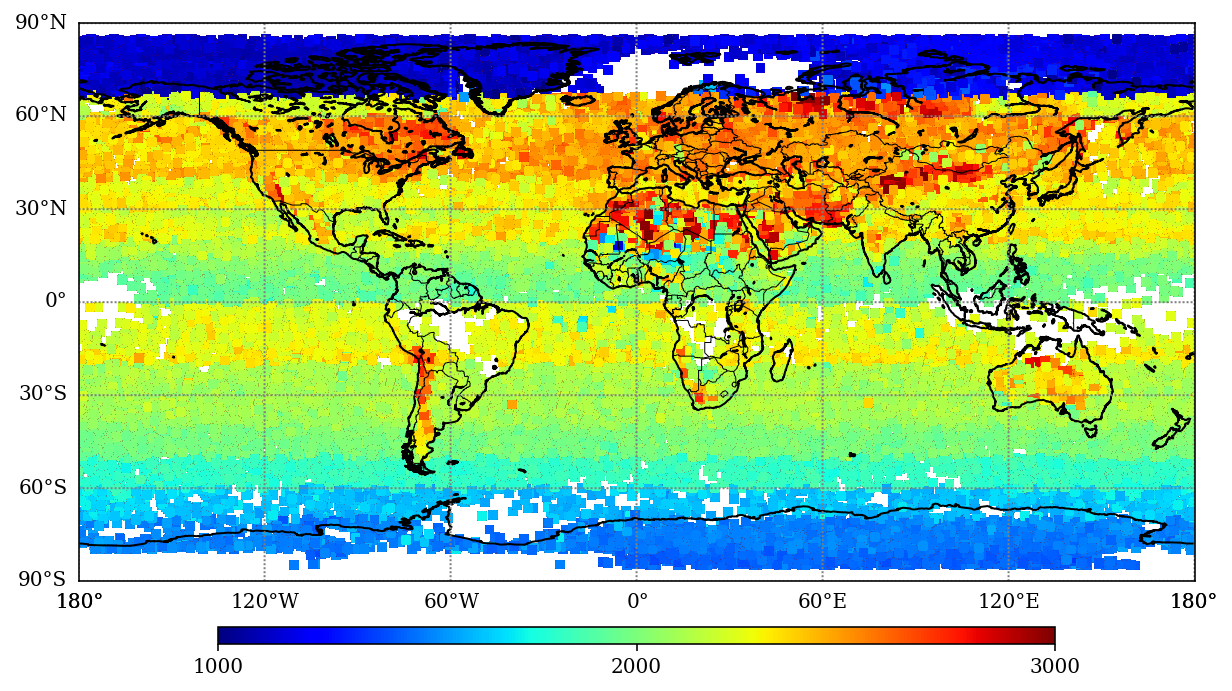

In [38]:
def plot_ll (df, map_lims, vc):
    # --- plot one figure panel
    def one_panel(i_ax, i_var, i_mp, i_x, i_y, i_lims, i_title, i_cmap):
        my_cmap = plt.get_cmap(i_cmap)
        var1d = np.array(i_var).flatten()
        sc = i_mp.scatter(i_x, i_y, c=var1d, s=ss, marker='s', 
                          cmap=my_cmap, vmin=i_lims[0], vmax=i_lims[-1])
        title = f'{i_title}'
        i_ax.set_title(title, loc='center', y=1.0, fontsize=fs - 1)
        return sc

    ss = map_lims[7]
    fs = map_lims[8]
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(10, 14), nrows=1, ncols=1, sharex='all', sharey='all')
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    mp = Basemap(projection='cyl', llcrnrlat=map_lims[0], urcrnrlat=map_lims[1],
                 llcrnrlon=map_lims[2], urcrnrlon=map_lims[3], resolution='l')

    lats = df['lat']
    lons = df['lon']
    x, y = mp(lons, lats)

    mp.ax = ax
    mp.drawcoastlines(color='k')
    mp.drawcountries(color='k')

#     subt = str(ix + 1) + ') ' + self.months[mn-1]
    stitle = '' #self.abc[0] + subt #+ 'GOSAT-TIR CH$_4$, ppb'
    sc = one_panel(ax, df['o3']*1e3, mp, x, y, vc, stitle, 'jet')

    # --- par/mer
    par = np.arange(-90, 91, map_lims[4])
    mp.drawparallels(par, labels=[1, 0, 1, 0], fontsize=fs, color='grey')
    mer = [False, True, False, True]
    mp.drawmeridians(np.arange(0, 360, map_lims[5]), labels=mer, fontsize=fs, color='grey')

    fig.colorbar(sc, ax=ax, orientation='horizontal', 
                 aspect=50, ticks=vc, shrink=.75, pad=0.03)

map_lims = [-90, 90, -180, 180, 30, 60, 1.0, 15, 10, 5]
vc = [0, 20, 40, 60]
vc = [1000, 2000, 3000]
plot_ll (df_s, map_lims, vc)

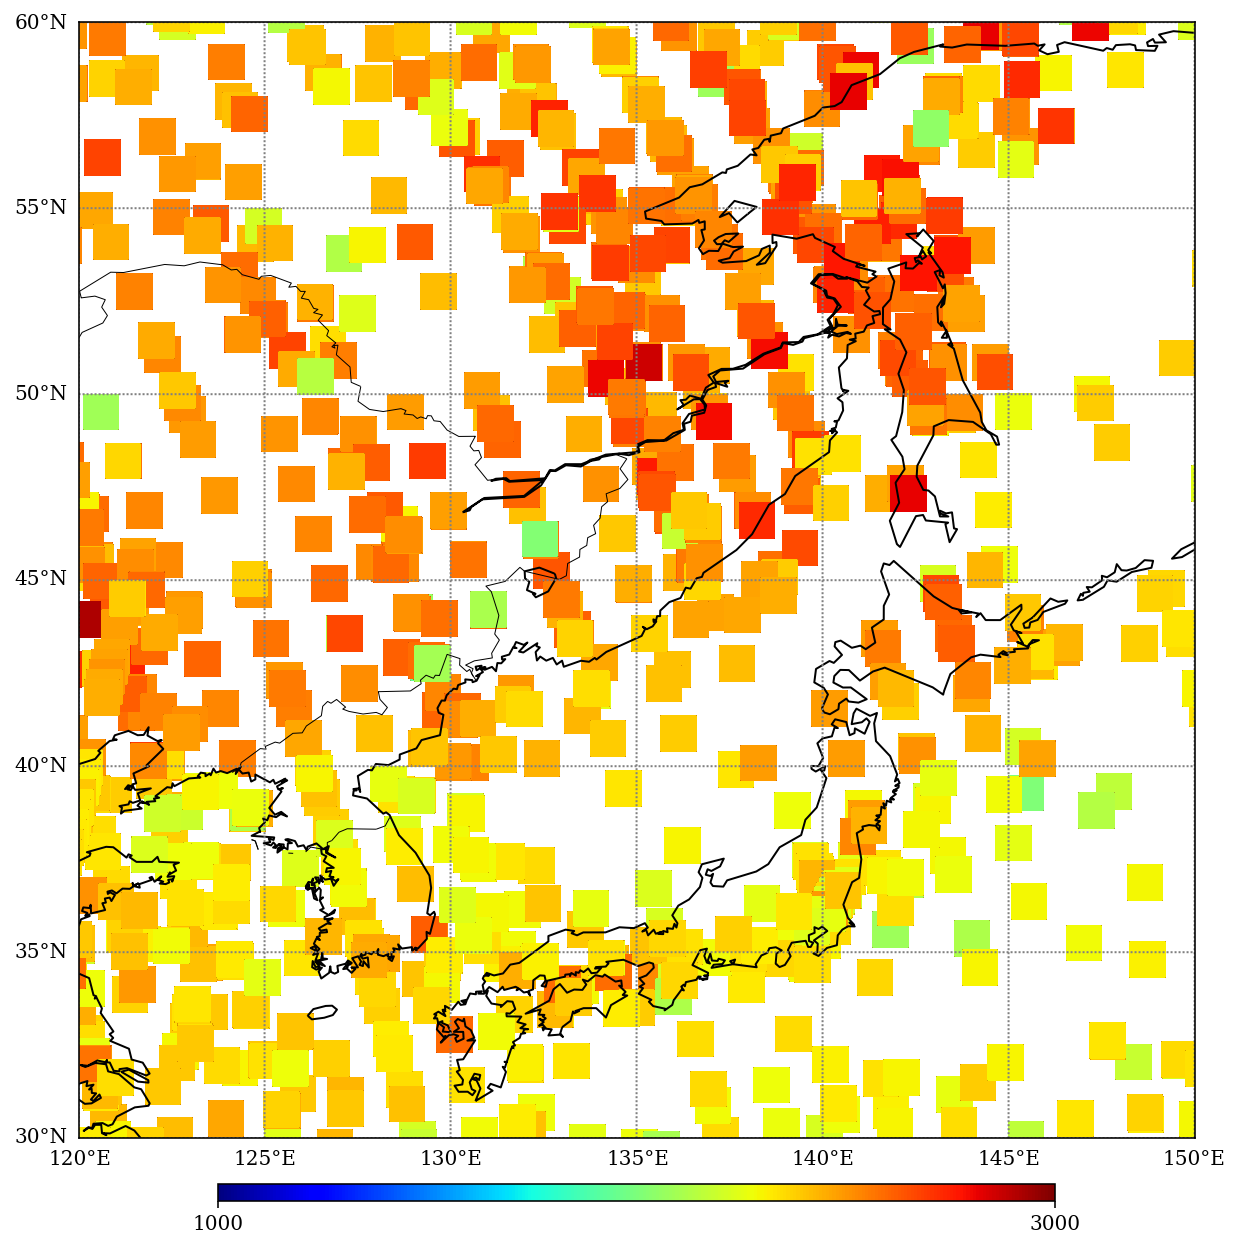

In [37]:
map_lims = [30, 60, 120, 150, 5, 5, 2.5, 300, 10, 5]
# vc = [20, 30, 40, 50]
vc = [1000, 2000, 3000]
plot_ll (df_s, map_lims, vc)

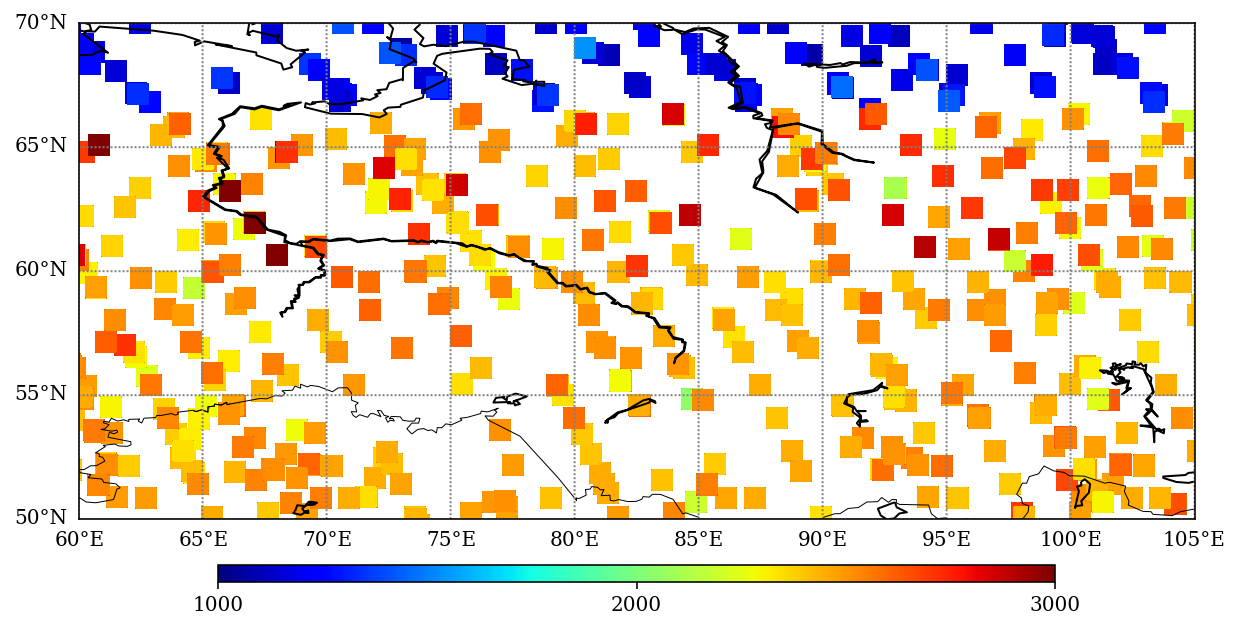

In [39]:
map_lims = [50, 70, 60, 105, 5, 5, 2.5, 100, 10, 5]
vc = [20, 30, 40]
vc = [1000, 2000, 3000]
plot_ll (df_s, map_lims, vc)

## To pickle

In [9]:
# pkf = 'D:\OneDrive - chiba-u.jp\Students\Ozone\mid_data\O3_V01_200910'
# pd.to_pickle(df, pkf)